<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f4f4f4; 
    border-radius: 10px; 
    align-items: center;">

<h1 style="margin: 0; color: #4CAF50;">Neural Networks: Convolutional Neural Networks (2)</h1>
<h2 style="margin: 5px 0; color: #555;">DSAI</h2>
<h3 style="margin: 5px 0; color: #555;">Jakob Eggl</h3>

<div style="flex-shrink: 0;">
    <img src="https://www.htl-grieskirchen.at/wp/wp-content/uploads/2022/11/logo_bildschirm-1024x503.png" alt="Logo" style="width: 250px; height: auto;"/>
</div>
<p1> © 2025/26 Jakob Eggl. Nutzung oder Verbreitung nur mit ausdrücklicher Genehmigung des Autors.</p1>
</div>
<div style="flex: 1;">
</div>   

Nachdem wir jetzt wissen, wie ein *Convolutional Neuronal Network* (**CNN**) funktioniert, wollen wir nun nochmal die Datasets **MNIST** und **Fashion-MNIST** ausprobieren.

Erstelle somit ein Neuronales Netzwerk, welches auf der CNN Architektur basiert und auf den Datasets **MNIST** und **Fashion-MNIST** trainiert wird.

# Lösung

Nun können wir testen, wie gut ein CNN bei unseren bisherigen Aufgaben (MNIST und Fashion MNIST performt).

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


## MNIST

In [3]:
data_path = os.path.join("..", "..", "_data", "mnist_data")

train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=transforms.ToTensor()) # ToTensor makes images [0, 1] instead of {1,2,...,255}
test_dataset  = datasets.MNIST(root=data_path, train=False, download=True, transform=transforms.ToTensor())

test_size = len(test_dataset) // 2
valid_size = len(test_dataset) - test_size

test_dataset, valid_dataset = random_split(test_dataset, [test_size, valid_size])

100.0%
100.0%
100.0%
100.0%


In [4]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Hier könnte man noch normalisieren und würde wahrscheinlich noch ein bisschen besser abscheiden. Man kann eigentlich direkt die `transform`-Methode vom `nn_8_example_classification_solution` übernehmen.

In [5]:
class CNNMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # output: 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 32 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # output: 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 7 x 7
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
    def forward(self, x):
        return self.layers(x)

In [6]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss_total += loss.item() * data.size(0)
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = loss_total / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [28]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, save_path:str=None,
                epochs=20, validate_at=1, print_at=100, patience=3):
    torch.set_num_threads(8)
    if save_path is None:
        save_path = 'best_model.pt'

    best_loss = float("inf")
    patience_counter = 0

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (batch_idx+1) % print_at == 0:
                print(f"Epoch [{epoch}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        if epoch % validate_at == 0:
            val_loss, val_acc = evaluate_model(model, valid_loader, criterion)
            print(f"Epoch [{epoch}/{epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
                print(f">>> Found a better model and saved it at '{save_path}'")
            else:
                patience_counter += 1
                print(f"No Improvement. Early Stopping Counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Early Stopping triggered.")
                    break

In [26]:
### HYPERPARAMETER ###

model = CNNMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 20
validate_at = 1
print_at = 200
early_stopping_patience = 3
save_path = os.path.join("..", "models", "best_model_cnn_mnist.pt")

In [29]:
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, validate_at=validate_at, print_at=print_at, patience=early_stopping_patience, save_path=save_path)

Epoch [1/20], Step [200/938], Loss: 0.7541
Epoch [1/20], Step [400/938], Loss: 0.4307
Epoch [1/20], Step [600/938], Loss: 0.4306
Epoch [1/20], Step [800/938], Loss: 0.3365
Epoch [1/20] - Validation Loss: 0.3727, Validation Accuracy: 86.10%
>>> Found a better model and saved it at '../models/best_model_cnn_mnist.pt'
Epoch [2/20], Step [200/938], Loss: 0.2701
Epoch [2/20], Step [400/938], Loss: 0.3223
Epoch [2/20], Step [600/938], Loss: 0.3573
Epoch [2/20], Step [800/938], Loss: 0.2421
Epoch [2/20] - Validation Loss: 0.3108, Validation Accuracy: 88.48%
>>> Found a better model and saved it at '../models/best_model_cnn_mnist.pt'
Epoch [3/20], Step [200/938], Loss: 0.2437
Epoch [3/20], Step [400/938], Loss: 0.2717
Epoch [3/20], Step [600/938], Loss: 0.3106
Epoch [3/20], Step [800/938], Loss: 0.2901
Epoch [3/20] - Validation Loss: 0.3020, Validation Accuracy: 88.68%
>>> Found a better model and saved it at '../models/best_model_cnn_mnist.pt'
Epoch [4/20], Step [200/938], Loss: 0.2356
Epoch 

In [10]:
model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Finaler Test Loss: {test_loss:.4f}")
print(f"Finale Test Accuracy: {test_acc:.2f}%")

Finaler Test Loss: 0.0260
Finale Test Accuracy: 98.88%


Also funktioniert auch dieses Modell sehr gut.

Probieren wir nun auch das Fashion-MNIST Dataset.

## Fashion MNIST

In [11]:
torch.cuda.empty_cache() # Clears GPU memory (otherwise it could run out of memory)

Nun testen wir das gleiche Modell (nur anders genannt) für Fashion MNIST.

In [12]:
data_path = os.path.join("..", "..", "_data", "fashion_mnist_data")

train_dataset = datasets.FashionMNIST(root=data_path, train=True, download=True, transform=transforms.ToTensor()) # ToTensor makes images [0, 1] instead of {1,2,...,255}
test_dataset  = datasets.FashionMNIST(root=data_path, train=False, download=True, transform=transforms.ToTensor())

test_size = len(test_dataset) // 2
valid_size = len(test_dataset) - test_size

test_dataset, valid_dataset = random_split(test_dataset, [test_size, valid_size])

100.0%
100.0%
100.0%
100.0%


In [13]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Erneut das gleiche Modell, jedoch anderer Name.

In [14]:
class CNNFashionMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # output: 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 32 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # output: 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 7 x 7
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
    def forward(self, x):
        return self.layers(x)

In [15]:
### HYPERPARAMETER ###

model = CNNFashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 20
validate_at = 1
print_at = 200
early_stopping_patience = 3
save_path = os.path.join("..", "models", "best_model_cnn_fashion_mnist.pt")

In [16]:
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, validate_at=validate_at, print_at=print_at, patience=early_stopping_patience, save_path=save_path)

Epoch [1/20], Step [200/938], Loss: 0.4498
Epoch [1/20], Step [400/938], Loss: 0.3739
Epoch [1/20], Step [600/938], Loss: 0.2920
Epoch [1/20], Step [800/938], Loss: 0.3433
Epoch [1/20] - Validation Loss: 0.3789, Validation Accuracy: 85.44%
>>> Found a better model and saved it at '../models/best_model_cnn_fashion_mnist.pt'
Epoch [2/20], Step [200/938], Loss: 0.3348
Epoch [2/20], Step [400/938], Loss: 0.3218
Epoch [2/20], Step [600/938], Loss: 0.2406
Epoch [2/20], Step [800/938], Loss: 0.2876
Epoch [2/20] - Validation Loss: 0.2920, Validation Accuracy: 88.96%
>>> Found a better model and saved it at '../models/best_model_cnn_fashion_mnist.pt'
Epoch [3/20], Step [200/938], Loss: 0.2267
Epoch [3/20], Step [400/938], Loss: 0.1655
Epoch [3/20], Step [600/938], Loss: 0.2643
Epoch [3/20], Step [800/938], Loss: 0.1533
Epoch [3/20] - Validation Loss: 0.2866, Validation Accuracy: 89.46%
>>> Found a better model and saved it at '../models/best_model_cnn_fashion_mnist.pt'
Epoch [4/20], Step [200/9

In [17]:
model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Finaler Test Loss: {test_loss:.4f}")
print(f"Finale Test Accuracy: {test_acc:.2f}%")

Finaler Test Loss: 0.2448
Finale Test Accuracy: 90.96%


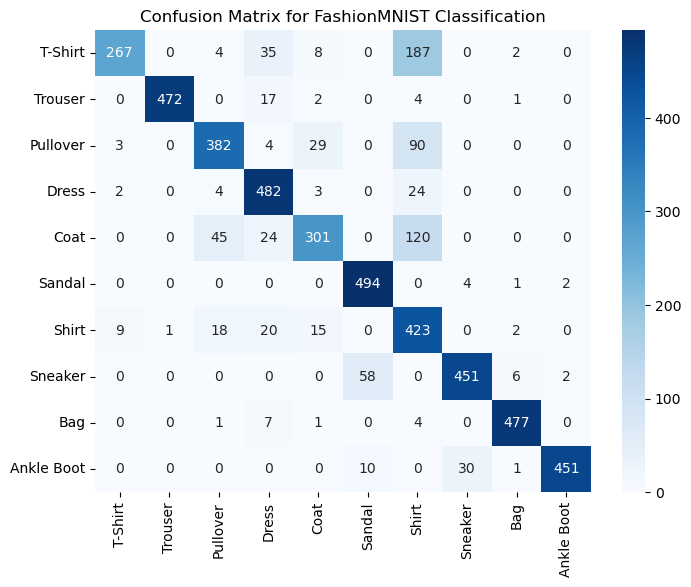

In [18]:
# Confusion Matrix of FashionMNIST model

label_dict = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

test_data = test_loader.dataset.dataset.data[test_loader.dataset.indices]
test_targets = test_loader.dataset.dataset.targets[test_loader.dataset.indices]

pred = model(test_data.unsqueeze(1).float().to(device))
cm = confusion_matrix(test_targets.cpu(), pred.argmax(dim=1).cpu())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.title("Confusion Matrix for FashionMNIST Classification")
plt.show()

Wir wollen das noch weiter verbessern und verwenden ein noch größeres Modell.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SigmaCNNFashionMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),    # -> 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # -> 64x28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                             # -> 64x14x14
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # -> 128x14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # -> 128x14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                             # -> 128x7x7
            nn.Dropout(0.25),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


**Hinweis:** Wie bereits vorher einmal angekündigt, verwenden wir hier auch "neue" Layers, welche wir jetzt nicht im Detail besprechen, bei Interesse sind diese aber leicht selber zu lernen.

In [20]:
### HYPERPARAMETER ###

model = SigmaCNNFashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
epochs = 20
validate_at = 1
print_at = 200
early_stopping_patience = 3
save_path = os.path.join("..", "models", "best_model_sophisticated_cnn_fashion_mnist.pt")

In [21]:
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, validate_at=validate_at, print_at=print_at, patience=early_stopping_patience, save_path=save_path)

Epoch [1/20], Step [200/938], Loss: 0.6775
Epoch [1/20], Step [400/938], Loss: 0.3635
Epoch [1/20], Step [600/938], Loss: 0.4439
Epoch [1/20], Step [800/938], Loss: 0.5197
Epoch [1/20] - Validation Loss: 0.3771, Validation Accuracy: 86.14%
>>> Found a better model and saved it at '../models/best_model_sophisticated_cnn_fashion_mnist.pt'
Epoch [2/20], Step [200/938], Loss: 0.2703
Epoch [2/20], Step [400/938], Loss: 0.2146
Epoch [2/20], Step [600/938], Loss: 0.5231
Epoch [2/20], Step [800/938], Loss: 0.3303
Epoch [2/20] - Validation Loss: 0.2523, Validation Accuracy: 90.44%
>>> Found a better model and saved it at '../models/best_model_sophisticated_cnn_fashion_mnist.pt'
Epoch [3/20], Step [200/938], Loss: 0.3770
Epoch [3/20], Step [400/938], Loss: 0.1671
Epoch [3/20], Step [600/938], Loss: 0.3214
Epoch [3/20], Step [800/938], Loss: 0.3550
Epoch [3/20] - Validation Loss: 0.2688, Validation Accuracy: 89.86%
No Improvement. Early Stopping Counter: 1/3
Epoch [4/20], Step [200/938], Loss: 0.

In [22]:
model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Finaler Test Loss: {test_loss:.4f}")
print(f"Finale Test Accuracy: {test_acc:.2f}%")

Finaler Test Loss: 0.2012
Finale Test Accuracy: 92.88%


In [23]:
torch.cuda.empty_cache()

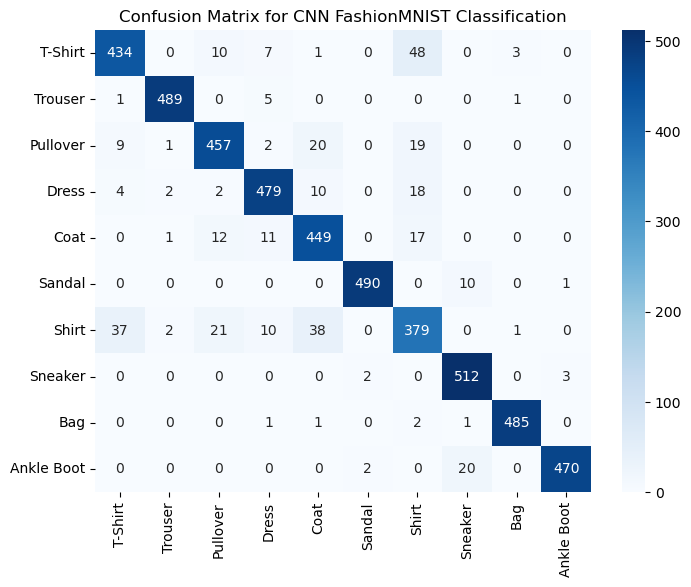

In [24]:
# Confusion Matrix of FashionMNIST model

# load best model

model.load_state_dict(torch.load(save_path))
model.eval()

label_dict = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

all_labels = []
predictions = []

for data, labels in test_loader:
    data = data.to(device)
    with torch.no_grad():
        outputs = model(data)
        predictions.append(outputs.argmax(dim=1).cpu().numpy())
        all_labels.append(labels.numpy())

cm = confusion_matrix(np.concatenate(all_labels), np.concatenate(predictions))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.title("Confusion Matrix for CNN FashionMNIST Classification")
plt.show()

Wie können wir das eventuell noch weiter verbessern?

Wir verwenden ein Pretrained Model und finetunen es auf unseren Daten.

> **Übung:** Lade dir ein Pretrained Model herunter (zBsp *ResNet18*) und trainiere es nochmal mit unserer Trainingsmethode für weitere 20 Epochen.